In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import nltk, warnings
import itertools
from statistics import mean
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from numpy import where
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
year_full=pd.read_csv('/content/drive/MyDrive/20210518_checks.csv')
year_full.head()

,client_id,day,shop_id,check_id,time,sku,promo_id,check_pos,num_sales,supplier_price,selling_price,region_name
0,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b17c870027bb4a22e3aedb971bc00def,b3deb0286313f0b888c0eac49580cc23,1,5.0,133.40,249.45,152f1b77a32508570e2745daf9ce7aec
1,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b9ef00e971d0fb459a765708efba70c0,680a96609351230ed00e1d1090371cbc,2,1.0,96.77,118.99,152f1b77a32508570e2745daf9ce7aec
2,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b75147feae4cf8ec07fb5f2cef855def,7215ee9c7d9dc229d2921a40e899ec5f,5,2.0,2.34,7.58,152f1b77a32508570e2745daf9ce7aec
3,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,b25e0d42165d246d23cbf4d3efcdf583,7215ee9c7d9dc229d2921a40e899ec5f,4,1.0,23.59,39.99,152f1b77a32508570e2745daf9ce7aec
4,d9da50b77962ad6401d0527db5b65b04,20191230,25bbdcd06c32d477f7fa1c3e4a91b032,c0b3f9c2215f924e27a6039617999c60,07:28:39,a537d2eef30d47f9b11d655421ca93fb,05c93d4fa9bdbe70b5d2204ce9548ca9,3,1.0,24.02,39.99,152f1b77a32508570e2745daf9ce7aec


In [ ]:
year_full=year_full.drop(['promo_id', 'shop_id', 'time', 'sku', 'check_pos', 'supplier_price', 'region_name'], axis=1)
year_full.head()

,client_id,day,check_id,num_sales,selling_price
0,d9da50b77962ad6401d0527db5b65b04,20191230,c0b3f9c2215f924e27a6039617999c60,5.0,249.45
1,d9da50b77962ad6401d0527db5b65b04,20191230,c0b3f9c2215f924e27a6039617999c60,1.0,118.99
2,d9da50b77962ad6401d0527db5b65b04,20191230,c0b3f9c2215f924e27a6039617999c60,2.0,7.58
3,d9da50b77962ad6401d0527db5b65b04,20191230,c0b3f9c2215f924e27a6039617999c60,1.0,39.99
4,d9da50b77962ad6401d0527db5b65b04,20191230,c0b3f9c2215f924e27a6039617999c60,1.0,39.99


In [ ]:
year_full['day']=year_full['day'].astype(str)
year_full['day'] = year_full['day'].apply(lambda x: dt.datetime.strptime(x,'%Y%m%d'))
year_full.head()

,client_id,day,check_id,num_sales,selling_price
0,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,5.0,249.45
1,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,1.0,118.99
2,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,2.0,7.58
3,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,1.0,39.99
4,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,1.0,39.99


In [ ]:
year_full['day'] = pd.to_datetime(year_full['day'])

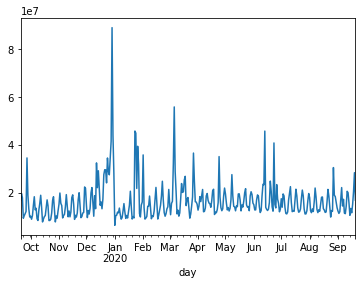

In [ ]:
year_full.groupby(['day'])['revenue'].sum().plot()

In [ ]:
year_full['revenue']=year_full['num_sales']*year_full['selling_price']

In [ ]:
year_full=year_full.drop(['selling_price', 'num_sales'], axis=1)

In [ ]:
year=year_full.groupby(['client_id','check_id']).agg({'revenue':'sum'})
P = np.percentile(year.revenue, [0, 98])
year = year[(year.revenue > P[0]) & (year.revenue < P[1])]

year=year.reset_index()
year_n=year_full.merge(year, on=['client_id','check_id'], how='inner')
year_n.head()

,client_id,day,check_id,revenue_x,revenue_y
0,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,1247.25,1461.38
1,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,118.99,1461.38
2,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,15.16,1461.38
3,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,39.99,1461.38
4,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,39.99,1461.38


In [ ]:
year1=year_n.groupby(['client_id']).agg({'check_id':'nunique'})
only_two=year1[year1['check_id']!=1]

only_two=only_two.reset_index()
year_n_two=year_n.merge(only_two, on='client_id', how='inner')
year_n_two.head()

,client_id,day,check_id_x,revenue_x,revenue_y,check_id_y
0,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,1247.25,1461.38,25
1,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,118.99,1461.38,25
2,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,15.16,1461.38,25
3,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,39.99,1461.38,25
4,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,39.99,1461.38,25


In [ ]:
year_n_two=year_n_two.drop_duplicates(subset=['client_id', 'check_id_x'])

In [ ]:
year_n_two=year_n_two.drop(['revenue_x', 'check_id_y'], axis=1)

In [ ]:
year_n_two['client_id'].nunique()

85081

In [ ]:
year_n_two.to_csv('short_new_cust_more2.csv')

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import nltk, warnings
import itertools
from statistics import mean
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from numpy import where
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
year_n_two=pd.read_csv('/content/drive/MyDrive/short_new_cust_more2.csv')
year_n_two.head()

,Unnamed: 0,client_id,day,check_id_x,revenue_y
0,0,d9da50b77962ad6401d0527db5b65b04,2019-12-30,c0b3f9c2215f924e27a6039617999c60,1461.38000
1,5,d9da50b77962ad6401d0527db5b65b04,2019-09-28,8c0ad344e85c88afde28aa5a9d389857,1358.13308
2,16,d9da50b77962ad6401d0527db5b65b04,2020-04-30,251d19016be24a4d9c3025d2b427ed5c,2083.12000
3,19,d9da50b77962ad6401d0527db5b65b04,2019-12-24,cc2d1d9657bd53908af502c23ece7f5c,2467.25152
4,29,d9da50b77962ad6401d0527db5b65b04,2020-04-24,372f365a08fc142664ad1104d35b8255,4232.57596


In [ ]:
year_n_two['day'] = pd.to_datetime(year_n_two['day'])

In [ ]:
year_copy_19=year_n_two[year_n_two['day']<=dt.datetime(2019,12,29)]
year_copy_20=year_n_two[year_n_two['day']>dt.datetime(2019,12,29)]

In [ ]:
year_copy_19['week']=[i.isocalendar()[1] for i in year_copy_19['day']]
year_copy_20['week']=[i.isocalendar()[1]+52 for i in year_copy_20['day']]

In [ ]:
year_copy = pd.concat([year_copy_19, year_copy_20], ignore_index=True)

In [ ]:
year_copy.head()

,Unnamed: 0,client_id,day,check_id_x,revenue_y,week
0,5,d9da50b77962ad6401d0527db5b65b04,2019-09-28,8c0ad344e85c88afde28aa5a9d389857,1358.13308,39
1,19,d9da50b77962ad6401d0527db5b65b04,2019-12-24,cc2d1d9657bd53908af502c23ece7f5c,2467.25152,52
2,100,d9da50b77962ad6401d0527db5b65b04,2019-12-17,397a1184dd366bbb98db4cd9f4b03a6a,2215.46000,51
3,192,d9da50b77962ad6401d0527db5b65b04,2019-12-02,a36878c7ce137b7fe7a57ed949b4dba8,1445.28000,49
4,210,936445a0ef613a41958d09bc17e1bada,2019-12-29,ad41c5c3a33cc9bd81f9ddcd682bcd64,818.00000,52


In [ ]:
year_copy.columns=['0','client_id', 'day', 'check_id', 'revenue', 'week']

In [ ]:
year_n_two.shape

(1814081, 5)

In [ ]:
#наверняка работает
def create_names(grouped,i=4):
  s=grouped.T.to_dict('list')
  new_s={}

  if week<100:
    for keys, values in s.items():
      if ((values[0]==grouped[f'Frequency{str(week)}'].min()) & (values[1]==grouped[f'Monetary{str(week)}'].min())) == True:
        new_s['sleeping'] = keys
      elif values[0]*values[1] == np.sort(grouped[f'Frequency{str(week)}']*grouped[f'Monetary{str(week)}'].to_list())[1]:
        new_s['average'] = keys
      elif values[0]*values[1] == np.sort(grouped[f'Frequency{str(week)}']*grouped[f'Monetary{str(week)}'].to_list())[2]:
        new_s['loyal'] = keys
      elif values[0]*values[1] == np.sort(grouped[f'Frequency{str(week)}']*grouped[f'Monetary{str(week)}'].to_list())[3]:
        new_s['champions'] = keys
  news=pd.DataFrame.from_dict(new_s, orient='index')
  news=news.reset_index()
  news.columns = [f'name{str(week)}',f'cluster{str(week)}']
  return news

In [ ]:
#3 кластера
def create_names(grouped,i=4):
  s=grouped.T.to_dict('list')
  new_s={}

  if week<100:
    for keys, values in s.items():
      if ((values[0]==grouped[f'Frequency{str(week)}'].min()) & (values[1]==grouped[f'Monetary{str(week)}'].min())) == True:
        new_s['sleeping'] = keys
      elif values[0]*values[1] == np.sort(grouped[f'Frequency{str(week)}']*grouped[f'Monetary{str(week)}'].to_list())[1]:
        new_s['loyal'] = keys
      elif values[0]*values[1] == np.sort(grouped[f'Frequency{str(week)}']*grouped[f'Monetary{str(week)}'].to_list())[2]:
        new_s['champions'] = keys
  news=pd.DataFrame.from_dict(new_s, orient='index')
  news=news.reset_index()
  news.columns = [f'name{str(week)}',f'cluster{str(week)}']
  return news

In [ ]:
year_copy1=year_copy.copy()
year1=year_copy1[year_copy1['week'] == 38]

frequency_df = year1.groupby(by=['client_id'], as_index=False)['check_id'].nunique()
frequency_df.columns = ['client_id','Frequency1']

monetary_df = year1.groupby(by='client_id',as_index=False).agg({'revenue': 'sum'})
monetary_df.columns = ['client_id','Monetary1']

fm_df = frequency_df.merge(monetary_df,on='client_id')
print(fm_df)
  #rfm_cl=pd.read_csv('https://raw.githubusercontent.com/gelya1709/customer_segmentation/main/rfm_periods_12/segments_kmeans0.csv')
rfm_cl=fm_df[['client_id','Monetary1']]

                              client_id  Frequency1   Monetary1
0      0005586058dff230bd98fc572cf3ad1b           1   130.00000
1      000a84ecdc62cb41a42327a5bf307221           3  3542.96118
2      001668f279a5798e46c0d79050004b72           1   155.00000
3      001c54509cd864d038f83f9efbd5696d           1  8807.52092
4      001da94244bab7dd0ea8bd5d1ef148a0           1  9031.49708
...                                 ...         ...         ...
11900  fff21ae050ff4e14da924ff06725dbd4           1  5563.34808
11901  fff3237113b2bccb18607c3d81ef95d5           1   768.62240
11902  fff5785cab25816ecd6b382b3aa8aeaf           3  9394.06000
11903  fffaac3531096a935b501a00e2d37026           1  4469.85260
11904  fffba136c9d96ba6f53739ce1244241c           1   310.12000

[11905 rows x 3 columns]


In [ ]:
year_copy['week'].unique()

array([39, 52, 51, 49, 48, 47, 50, 43, 38, 42, 40, 46, 44, 41, 45, 53, 70,
       69, 87, 89, 79, 73, 77, 86, 85, 71, 72, 84, 83, 62, 60, 63, 55, 65,
       56, 64, 54, 59, 76, 66, 75, 81, 78, 82, 88, 61, 68, 90, 57, 80, 74,
       67, 58])

In [ ]:

year_copy1=year_copy.copy()
dates=list(set(year_copy1['week'].to_list()))

for week in dates:
  year1=year_copy1[year_copy1['week'] == week]

  frequency_df = year1.groupby(by=['client_id'], as_index=False)['check_id'].nunique()
  frequency_df.columns = ['client_id',f'Frequency{str(week)}']

  monetary_df = year1.groupby(by='client_id',as_index=False).agg({'revenue': 'sum'})
  monetary_df.columns = ['client_id',f'Monetary{str(week)}']

  fm_df = frequency_df.merge(monetary_df,on='client_id')
  #print(fm_df)
  
  #print(fm_df)
  scaler = StandardScaler()
  rfm_normalised = fm_df[[f'Frequency{str(week)}',f'Monetary{str(week)}']]
  scaler.fit(rfm_normalised)
  scaled_matrix = scaler.transform(rfm_normalised)
  scaled_matrix=pd.DataFrame(scaled_matrix)

  model1 = LocalOutlierFactor(n_neighbors = 5, metric = "manhattan", contamination = 0.05)
  #print(scaled_matrix)
  y_pred = model1.fit_predict(scaled_matrix)
  index=where(y_pred==1)
  scaled_matrix = scaled_matrix.iloc[index]
  print(scaled_matrix.shape)


  kmeans = KMeans(init='k-means++', n_clusters = 3, max_iter=100)
  kmeans.fit(scaled_matrix)
  cluster_lables=kmeans.labels_
  silhouette_avg = silhouette_score(scaled_matrix, cluster_lables)
  #print(silhouette_avg)
  scaled_matrix.loc[:,'client_id']=fm_df['client_id']
  scaled_matrix[f'cluster{str(week)}']=kmeans.labels_
  clusters=fm_df.merge(scaled_matrix[['client_id',f'cluster{str(week)}']], on='client_id')
  print(clusters.shape)

  grouped=clusters[[f'cluster{str(week)}', f'Frequency{str(week)}',f'Monetary{str(week)}']].groupby([f'cluster{str(week)}']).mean()
  #print(clusters.groupby(f'cluster{str(week)}').count())
  news=create_names(grouped, i={str(week)})
  print(news.shape)
  clusters1=clusters.merge(news, on=f'cluster{str(week)}', how='left')
  rfm_cl=rfm_cl.merge(clusters1[['client_id',f'name{str(week)}']], on='client_id', how='outer')
#print(rfm_cl)
rfm_cl.drop(["Monetary1"], axis=1, inplace=True)
rfm_cl.to_csv('3clusters_38_allweeks.csv')